# 메시징 발송량 분석 및 모델링 하기

### 1. fbprophet 이용하기
### 2. 전력량 예측 모델링 이용하기 (LSTM)
### 3. LSTM statueful=True 이용하기

In [1]:
# fbprophet 설치하기
!pip install convertdate            
!pip install pystan
!pip install lunarcalendar
!pip install holidays
!pip install plotly

Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 43 kB 43.9 MB/s eta 0:00:01
     |████████████████████████████████| 732 kB 104.3 MB/s eta 0:00:01
  Created wheel for pymeeus: filename=PyMeeus-0.3.7-py3-none-any.whl size=691116 sha256=48a4728941c89332ee6aabcee9ee23c89c9588ec759214cb6301a7b4c766e6ce
  Stored in directory: /root/.cache/pip/wheels/bd/75/0e/7a15ff0675e487343a49ef447ae04cfc631753cbda09b6e8ac
Successfully built pymeeus
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 67.3 MB 104.5 MB/s eta 0:00:01B 104.5 MB/s eta 0:00:01��                          | 12.3 MB 104.5 MB/s eta 0:00:0101��███▌                      | 20.0 MB 104.5 MB/s eta 0:00:01█▉                    | 24.9 MB 104.5 MB/s eta 0:00:01        | 29.5 MB 104.5 MB/s eta 0:00:01/s eta 0:00:01��██████████████              | 37.8 MB 104.5 MB/s

In [2]:
!pip install fbprophet

Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 54 kB 71.0 MB/s eta 0:00:01
  Created wheel for fbprophet: filename=fbprophet-0.6-py3-none-any.whl size=6617928 sha256=aa98afbbc65d43496c2ab53f431b385c23c5d5f672f66c915df3af8c12cc16ff
  Stored in directory: /root/.cache/pip/wheels/ea/99/cb/785e45b5d501cd026ddc83634b4aaea7de15347feb70af8397
Successfully built fbprophet
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!pip install seaborn

Looking in indexes: http://10.220.235.19/pypi/simple
     |████████████████████████████████| 215 kB 88.2 MB/s eta 0:00:01████████████████████████████   | 194 kB 88.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import datetime
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from fbprophet import Prophet

In [5]:
#AIDU 내부 연동을 위한 라이브러리
from aicentro.session import Session
from aicentro.framework.keras import Keras as AiduFrm

In [6]:
# AIDU와 연동을 위한 변수
aidu_session = Session(verify=False)
aidu_framework = AiduFrm(session=aidu_session)

In [7]:
df = pd.read_csv(aidu_framework.config.data_dir + '/발송메시지현황_2호기_6월7월1.csv',header=None)

In [8]:
df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,2020-06-01 23:00,"210,695","202,944","7,751",0,"144,284","141,023","3,261","64,812","60,364",...,35,0,27,21,6,0,6,5,1,0
1,2020-06-01 22:00,"338,710","327,311","11,399",0,"213,213","208,190","5,023","123,466","117,140",...,36,0,78,67,11,0,13,10,3,0
2,2020-06-01 21:00,"511,049","495,486","15,563",0,"321,438","314,767","6,671","185,907","177,135",...,83,0,236,207,29,0,63,55,8,0
3,2020-06-01 20:00,"2,752,845","2,663,078","89,767",0,"2,369,185","2,299,776","69,409","375,369","355,509",...,128,0,"1,944","1,578",366,0,44,40,4,0
4,2020-06-01 19:00,"3,601,939","3,355,711","246,228",0,"2,625,622","2,443,388","182,234","965,221","901,933",...,272,0,"2,179","1,759",420,0,68,54,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-07-31 4:00,"85,255","80,193","5,062",0,"64,218","62,659","1,559","20,602","17,134",...,8,0,45,18,27,0,2,2,0,0
1460,2020-07-31 3:00,"72,993","68,247","4,746",0,"53,356","51,613","1,743","19,091","16,122",...,8,0,41,15,26,0,0,0,0,0
1461,2020-07-31 2:00,"69,149","62,820","6,329",0,"43,856","41,931","1,925","24,709","20,359",...,12,0,80,40,40,0,15,13,2,0
1462,2020-07-31 1:00,"106,705","98,247","8,458",0,"71,720","69,191","2,529","33,975","28,098",...,16,0,57,21,36,0,0,0,0,0


In [9]:
df.columns = ['요청일시','전체성공','전체실패','전체대기','SMS요청','SMS성공','SMS실패','SMS대기','LMS성공','LMS실패','LMS대기','IMAGE요청',
'IMAGE성공','IMAGE실패','IMAGE대기','VMS요청','VMS성공','VMS실패','VMS대기','FMS요청','FMS성공','FMS실패','FMS대기','모름']

In [10]:
df

,요청일시,전체성공,전체실패,전체대기,SMS요청,SMS성공,SMS실패,SMS대기,LMS성공,LMS실패,...,IMAGE대기,VMS요청,VMS성공,VMS실패,VMS대기,FMS요청,FMS성공,FMS실패,FMS대기,모름
0,2020-06-01 23:00,"210,695","202,944","7,751",0,"144,284","141,023","3,261","64,812","60,364",...,35,0,27,21,6,0,6,5,1,0
1,2020-06-01 22:00,"338,710","327,311","11,399",0,"213,213","208,190","5,023","123,466","117,140",...,36,0,78,67,11,0,13,10,3,0
2,2020-06-01 21:00,"511,049","495,486","15,563",0,"321,438","314,767","6,671","185,907","177,135",...,83,0,236,207,29,0,63,55,8,0
3,2020-06-01 20:00,"2,752,845","2,663,078","89,767",0,"2,369,185","2,299,776","69,409","375,369","355,509",...,128,0,"1,944","1,578",366,0,44,40,4,0
4,2020-06-01 19:00,"3,601,939","3,355,711","246,228",0,"2,625,622","2,443,388","182,234","965,221","901,933",...,272,0,"2,179","1,759",420,0,68,54,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-07-31 4:00,"85,255","80,193","5,062",0,"64,218","62,659","1,559","20,602","17,134",...,8,0,45,18,27,0,2,2,0,0
1460,2020-07-31 3:00,"72,993","68,247","4,746",0,"53,356","51,613","1,743","19,091","16,122",...,8,0,41,15,26,0,0,0,0,0
1461,2020-07-31 2:00,"69,149","62,820","6,329",0,"43,856","41,931","1,925","24,709","20,359",...,12,0,80,40,40,0,15,13,2,0
1462,2020-07-31 1:00,"106,705","98,247","8,458",0,"71,720","69,191","2,529","33,975","28,098",...,16,0,57,21,36,0,0,0,0,0


In [11]:
df['요청일시'] = pd.to_datetime(df['요청일시'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   요청일시     1464 non-null   datetime64[ns]
 1   전체성공     1464 non-null   object        
 2   전체실패     1464 non-null   object        
 3   전체대기     1464 non-null   object        
 4   SMS요청    1464 non-null   object        
 5   SMS성공    1464 non-null   object        
 6   SMS실패    1464 non-null   object        
 7   SMS대기    1464 non-null   object        
 8   LMS성공    1464 non-null   object        
 9   LMS실패    1464 non-null   object        
 10  LMS대기    1464 non-null   object        
 11  IMAGE요청  1464 non-null   int64         
 12  IMAGE성공  1464 non-null   object        
 13  IMAGE실패  1464 non-null   object        
 14  IMAGE대기  1464 non-null   object        
 15  VMS요청    1464 non-null   int64         
 16  VMS성공    1464 non-null   object        
 17  VMS실패    1464 non-null   object  

In [13]:
df.select_dtypes('O').columns

Index(['전체성공', '전체실패', '전체대기', 'SMS요청', 'SMS성공', 'SMS실패', 'SMS대기', 'LMS성공',
       'LMS실패', 'LMS대기', 'IMAGE성공', 'IMAGE실패', 'IMAGE대기', 'VMS성공', 'VMS실패',
       'VMS대기', 'FMS성공', 'FMS실패', 'FMS대기'],
      dtype='object')

In [14]:
col_list = ['전체성공', '전체실패', '전체대기', 'SMS요청', 'SMS성공', 'SMS실패', 'SMS대기', 'LMS성공',
       'LMS실패', 'LMS대기', 'IMAGE성공', 'IMAGE실패', 'IMAGE대기', 'VMS성공', 'VMS실패',
       'VMS대기', 'FMS성공', 'FMS실패', 'FMS대기']

In [15]:
for col in col_list:
    df[col] = df[col].str.replace(',','').astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1464 entries, 0 to 1463
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   요청일시     1464 non-null   datetime64[ns]
 1   전체성공     1464 non-null   int64         
 2   전체실패     1464 non-null   int64         
 3   전체대기     1464 non-null   int64         
 4   SMS요청    1464 non-null   int64         
 5   SMS성공    1464 non-null   int64         
 6   SMS실패    1464 non-null   int64         
 7   SMS대기    1464 non-null   int64         
 8   LMS성공    1464 non-null   int64         
 9   LMS실패    1464 non-null   int64         
 10  LMS대기    1464 non-null   int64         
 11  IMAGE요청  1464 non-null   int64         
 12  IMAGE성공  1464 non-null   int64         
 13  IMAGE실패  1464 non-null   int64         
 14  IMAGE대기  1464 non-null   int64         
 15  VMS요청    1464 non-null   int64         
 16  VMS성공    1464 non-null   int64         
 17  VMS실패    1464 non-null   int64   

In [17]:
df

,요청일시,전체성공,전체실패,전체대기,SMS요청,SMS성공,SMS실패,SMS대기,LMS성공,LMS실패,...,IMAGE대기,VMS요청,VMS성공,VMS실패,VMS대기,FMS요청,FMS성공,FMS실패,FMS대기,모름
0,2020-06-01 23:00:00,210695,202944,7751,0,144284,141023,3261,64812,60364,...,35,0,27,21,6,0,6,5,1,0
1,2020-06-01 22:00:00,338710,327311,11399,0,213213,208190,5023,123466,117140,...,36,0,78,67,11,0,13,10,3,0
2,2020-06-01 21:00:00,511049,495486,15563,0,321438,314767,6671,185907,177135,...,83,0,236,207,29,0,63,55,8,0
3,2020-06-01 20:00:00,2752845,2663078,89767,0,2369185,2299776,69409,375369,355509,...,128,0,1944,1578,366,0,44,40,4,0
4,2020-06-01 19:00:00,3601939,3355711,246228,0,2625622,2443388,182234,965221,901933,...,272,0,2179,1759,420,0,68,54,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2020-07-31 04:00:00,85255,80193,5062,0,64218,62659,1559,20602,17134,...,8,0,45,18,27,0,2,2,0,0
1460,2020-07-31 03:00:00,72993,68247,4746,0,53356,51613,1743,19091,16122,...,8,0,41,15,26,0,0,0,0,0
1461,2020-07-31 02:00:00,69149,62820,6329,0,43856,41931,1925,24709,20359,...,12,0,80,40,40,0,15,13,2,0
1462,2020-07-31 01:00:00,106705,98247,8458,0,71720,69191,2529,33975,28098,...,16,0,57,21,36,0,0,0,0,0


In [18]:
df1 = df[['요청일시','전체성공']]

In [19]:
df1.columns = ['ds','y']

In [20]:
df2 = df1.sort_values(['ds']).reset_index(drop=True)

In [21]:
df2

,ds,y
0,2020-06-01 00:00:00,158159
1,2020-06-01 01:00:00,88857
2,2020-06-01 02:00:00,66580
3,2020-06-01 03:00:00,79068
4,2020-06-01 04:00:00,156012
...,...,...
1459,2020-07-31 19:00:00,2900991
1460,2020-07-31 20:00:00,4794829
1461,2020-07-31 21:00:00,709262
1462,2020-07-31 22:00:00,427875


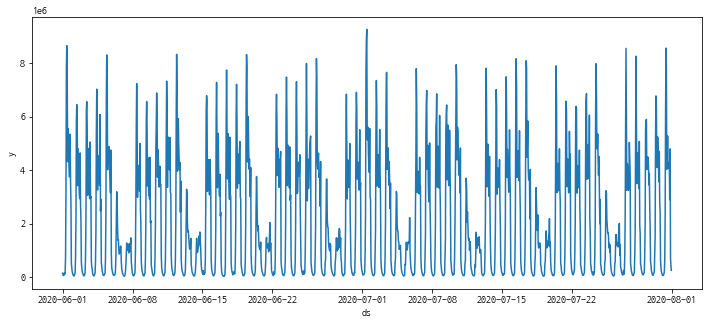

In [22]:
plt.figure(figsize=(12,5))
sns.lineplot(x='ds',y='y', data=df2)

## Fbprophet 모델링 하기

In [23]:
# prophet 실행
m = Prophet()
m.fit(df2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [24]:
### 미래 트래픽 예측을 위해 예측기간(periods) 및 데이터 간격(freq)을 지정한다.
### 1시간 간격으로 168회(7일:24*7) 예측 실행
future = m.make_future_dataframe(periods=168, freq='H' )
future.tail()

,ds
1627,2020-08-07 19:00:00
1628,2020-08-07 20:00:00
1629,2020-08-07 21:00:00
1630,2020-08-07 22:00:00
1631,2020-08-07 23:00:00


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



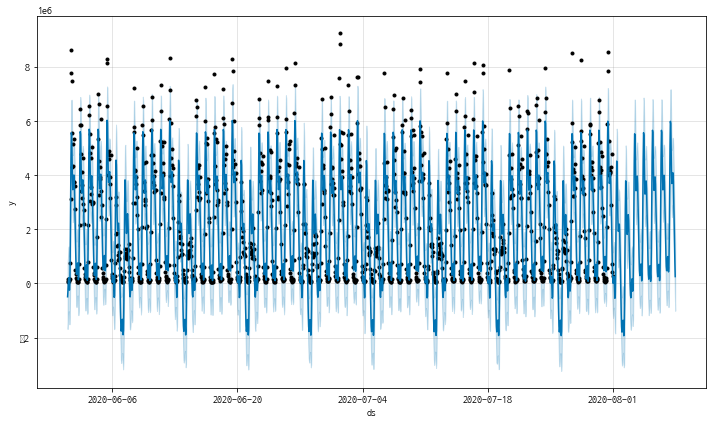

In [25]:
### 머신러닝을 수행하고 결과를 보여준다.
### 머신러닝 결과는 yhat, yhat_upper, yhat_lower 컬럼으로 나뉘어져 있으며 각각 예측치 평균, 최대 예측치, 최소 예측치를 의미한다.
forecast = m.predict(future)
fig1 = m.plot(forecast)

In [26]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1627,2020-08-07 19:00:00,3.124347e+06,1.821795e+06,4.304543e+06
1628,2020-08-07 20:00:00,2.347395e+06,1.158688e+06,3.634970e+06
1629,2020-08-07 21:00:00,1.550045e+06,2.867593e+05,2.747226e+06
1630,2020-08-07 22:00:00,8.130943e+05,-4.659437e+05,2.192475e+06
1631,2020-08-07 23:00:00,2.536627e+05,-1.011263e+06,1.494987e+06


## 기존 전력량 예측 모델 이용하기

In [27]:
series = df2['y'].values

In [28]:
len(series)

1464

In [29]:
# 데이터셋을 입력데이터와 타깃데이터로 분리하는 함수입니다.
def split_data_input_label(dataset, start_index, end_index, hist_data_size, target_size):
    data = []
    labels = []

    start_index = start_index + hist_data_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-hist_data_size, i)
        # Reshape data from (hist_data_size,) to (hist_data_size, 1)
        data.append(np.reshape(dataset[indices], (hist_data_size, 1)))
        labels.append([dataset[i+target_size]])
    return np.array(data), np.array(labels)

In [30]:
# 시계열 데이터를 정규화합니다
train_split = 1150 # 365일 * 2년 * 96개데이터
test_split = 1150 # 365일 * 3년 * 96개데이터

train_data_mean = series.mean()
train_data_std = series.std()
dataset = (series - train_data_mean)/train_data_std

In [31]:
# 훈련 데이터셋과 검증 데이터셋으로 데이터를 분할합니다.
n_steps = 24*7
future_target = 0

X_train, y_train = split_data_input_label(dataset, 0,train_split, 
                                          n_steps, 
                                          future_target)
X_valid, y_valid = split_data_input_label(dataset,train_split,len(series), 
                                          n_steps, 
                                          future_target)
# X_test, _ = split_data_input_label(dataset, test_split, len(series), 
#                                    n_steps, 
#                                    future_target)

In [32]:
X_train.shape

(982, 168, 1)

In [33]:
series[:7]

array([158159,  88857,  66580,  79068, 156012, 111326, 167996])

In [34]:
# 입력데이터, 타깃데이터, 예측데이터를 그래프로 출력하는 함수입니다
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, min(series) - abs(min(series)/10) , max(series) + abs(max(series)/10)])

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 8722 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 8722 missing from current font.



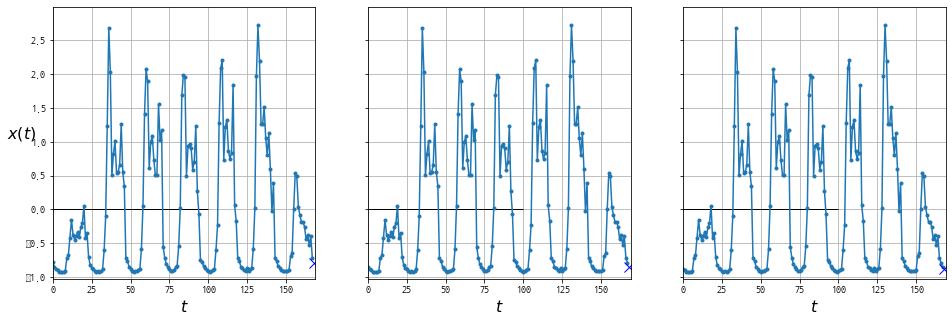

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(16, 5))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [36]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [38]:
# 신경망 모델 구성 설정
np.random.seed(42)

mc = ModelCheckpoint('lstm_best_model1.h5', monitor='val_loss', save_best_only=True, verbose=1)
es = EarlyStopping(monitor='val_loss', patience=4)

model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, input_shape=(n_steps, 1)),
    keras.layers.LSTM(32),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="sgd", metrics=["mse", "mae"])
history = model.fit(X_train, y_train, epochs=100,
                    callbacks=[mc,es],
                    validation_data=(X_valid, y_valid))

Epoch 1/100
31/31 [==============================] - ETA: 0s - loss: 0.9207 - mse: 0.9207 - mae: 0.8138
Epoch 00001: val_loss improved from inf to 0.92018, saving model to lstm_best_model1.h5
31/31 [==============================] - 8s 257ms/step - loss: 0.9207 - mse: 0.9207 - mae: 0.8138 - val_loss: 0.9202 - val_mse: 0.9202 - val_mae: 0.8203
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 0.8374 - mse: 0.8374 - mae: 0.7671
Epoch 00002: val_loss improved from 0.92018 to 0.83708, saving model to lstm_best_model1.h5
31/31 [==============================] - 7s 235ms/step - loss: 0.8374 - mse: 0.8374 - mae: 0.7671 - val_loss: 0.8371 - val_mse: 0.8371 - val_mae: 0.7696
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.7607 - mse: 0.7607 - mae: 0.7173
Epoch 00003: val_loss improved from 0.83708 to 0.76017, saving model to lstm_best_model1.h5
31/31 [==============================] - 7s 239ms/step - loss: 0.7607 - mse: 0.7607 - mae: 0.7173 - val_loss: 

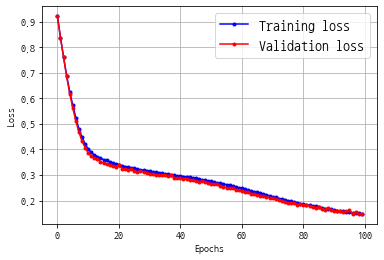

In [39]:
plt.plot(history.history["loss"], "b.-", label="Training loss")
plt.plot(history.history["val_loss"], "r.-", label="Validation loss")
plt.legend(fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [40]:
model = load_model('lstm_best_model1.h5')

In [41]:
model.evaluate(X_valid, y_valid)

5/5 [==============================] - 0s 33ms/step - loss: 0.1477 - mean_squared_error: 0.1477 - mean_absolute_error: 0.2670


[0.1476925015449524, 0.1476925015449524, 0.2670319080352783]

In [42]:
y_valid_pred = model.predict(X_valid, batch_size=1)

In [43]:
YY_valid_pred = np.array(y_valid_pred)*train_data_std+train_data_mean
YY_valid = np.array(y_valid)*train_data_std+train_data_mean

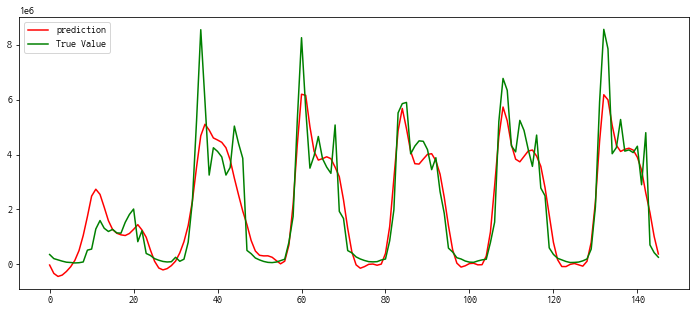

In [44]:
plt.figure(figsize=(12,5))
plt.plot(list(range(0,len(YY_valid_pred))),YY_valid_pred.flatten(),'r',label="prediction")
plt.plot(list(range(0,len(YY_valid_pred))),YY_valid.flatten(),'g',label="True Value")
plt.legend()
plt.show()

### 24 시간 미리 예측해 보기

In [45]:
# 예측건수 , 단위 : Hour
pred_count = 24

In [46]:
seq_in = X_valid[145].flatten().tolist()
seq_out = X_valid[145].flatten().tolist()

In [47]:
len(seq_in), len(seq_out)

(168, 168)

In [48]:
for i in range(pred_count):
    sample_in = np.array(seq_in)
    pred_out = model.predict(sample_in.reshape(1,n_steps,1))
    #scale_pred_out = pred_out[0, 0]*train_data_std+train_data_mean
    scale_pred_out = pred_out[0, 0]
    seq_out.append(scale_pred_out)
    seq_in.append(scale_pred_out)
    seq_in.pop(0)

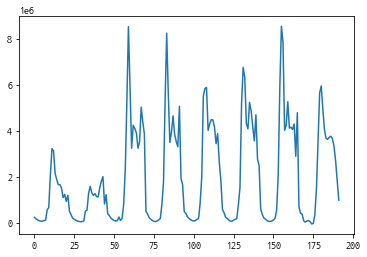

In [49]:
Y1 = np.array(seq_out)*train_data_std+train_data_mean
X1 = range(len(Y1))
sns.lineplot(X1,Y1)

## LSTM stateful=True 

In [82]:
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [83]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [84]:
# 신경망 모델 구성 설정
np.random.seed(42)

mc = ModelCheckpoint('lstm_best_model2.h5', monitor='val_loss', save_best_only=True, verbose=1)
#es = EarlyStopping(monitor='val_loss', patience=4)

model = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, batch_input_shape=(1,n_steps, 1), stateful=True),
    keras.layers.LSTM(64, stateful=True),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam", metrics=["mse", "mae"])

custom_hist = CustomHistory()
custom_hist.init()

for i in range(50):
    model.fit(X_train, y_train, epochs=1, batch_size=1, shuffle=False, callbacks=[mc, custom_hist], validation_data=(X_valid, y_valid))
    model.reset_states()

982/982 [==============================] - ETA: 0s - loss: 0.5593 - mse: 0.5593 - mae: 0.5508
Epoch 00001: val_loss improved from inf to 0.34789, saving model to lstm_best_model2.h5
982/982 [==============================] - ETA: 0s - loss: 0.2202 - mse: 0.2202 - mae: 0.3320
Epoch 00001: val_loss improved from 0.34789 to 0.16490, saving model to lstm_best_model2.h5
982/982 [==============================] - ETA: 0s - loss: 0.1499 - mse: 0.1499 - mae: 0.2614
Epoch 00001: val_loss improved from 0.16490 to 0.09599, saving model to lstm_best_model2.h5
982/982 [==============================] - ETA: 0s - loss: 0.1265 - mse: 0.1265 - mae: 0.2355
Epoch 00001: val_loss improved from 0.09599 to 0.09325, saving model to lstm_best_model2.h5
982/982 [==============================] - ETA: 0s - loss: 0.1168 - mse: 0.1168 - mae: 0.2215
Epoch 00001: val_loss improved from 0.09325 to 0.07790, saving model to lstm_best_model2.h5
982/982 [==============================] - ETA: 0s - loss: 0.1031 - mse: 0

In [85]:
model = load_model('lstm_best_model2.h5')

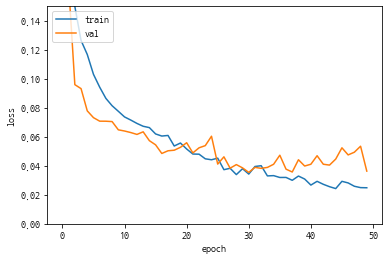

In [86]:
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [87]:
X_train.shape, X_valid.shape

((982, 168, 1), (146, 168, 1))

In [88]:
score = model.evaluate(X_valid, y_valid, batch_size=1)
model.reset_states()
print('Validation Score: ', score)

146/146 [==============================] - 3s 19ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1247
Validation Score:  [0.03546503931283951, 0.03546503931283951, 0.12471029162406921]


In [89]:
X_valid.shape

(146, 168, 1)

In [90]:
y_valid_pred = model.predict(X_valid, batch_size=1)

In [91]:
YY_valid_pred = np.array(y_valid_pred)*train_data_std+train_data_mean
YY_valid = np.array(y_valid)*train_data_std+train_data_mean

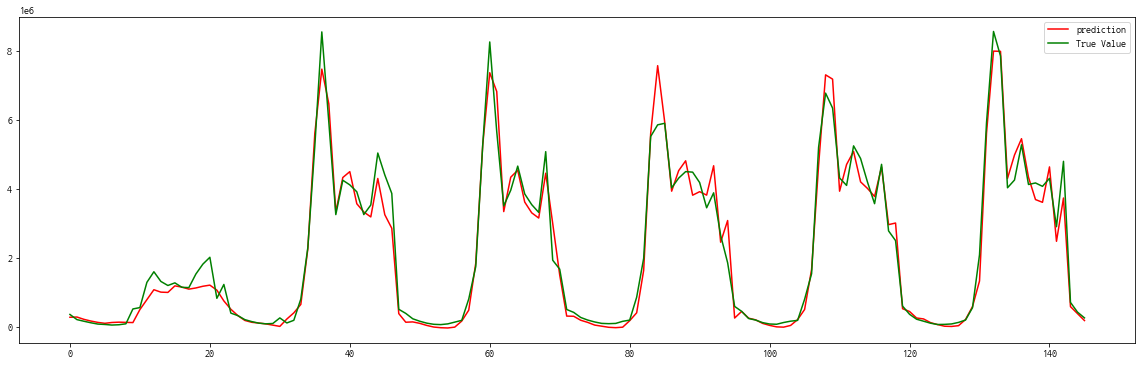

In [94]:
plt.figure(figsize=(20,6))
plt.plot(list(range(0,len(YY_valid_pred))),YY_valid_pred.flatten(),'r',label="prediction")
plt.plot(list(range(0,len(YY_valid_pred))),YY_valid.flatten(),'g',label="True Value")
plt.legend()
plt.show()